In [580]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [581]:
country_to_predict="Republic of Congo"

**ARIMA**


In [582]:
df=pd.read_excel('test_arima.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
df.index.freq = 'YS'
df.head()

,Year,Value,Country
98,1970-01-01,50.725,Republic of Congo
99,1971-01-01,51.126,Republic of Congo
100,1972-01-01,51.514,Republic of Congo
101,1973-01-01,51.888,Republic of Congo
102,1974-01-01,52.249,Republic of Congo


In [583]:
del df["Country"]

In [584]:
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.head()
df.index.freq = 'YS'

In [585]:
train_df = df[:len(df)-6]
test_df = df[len(df)-6:]

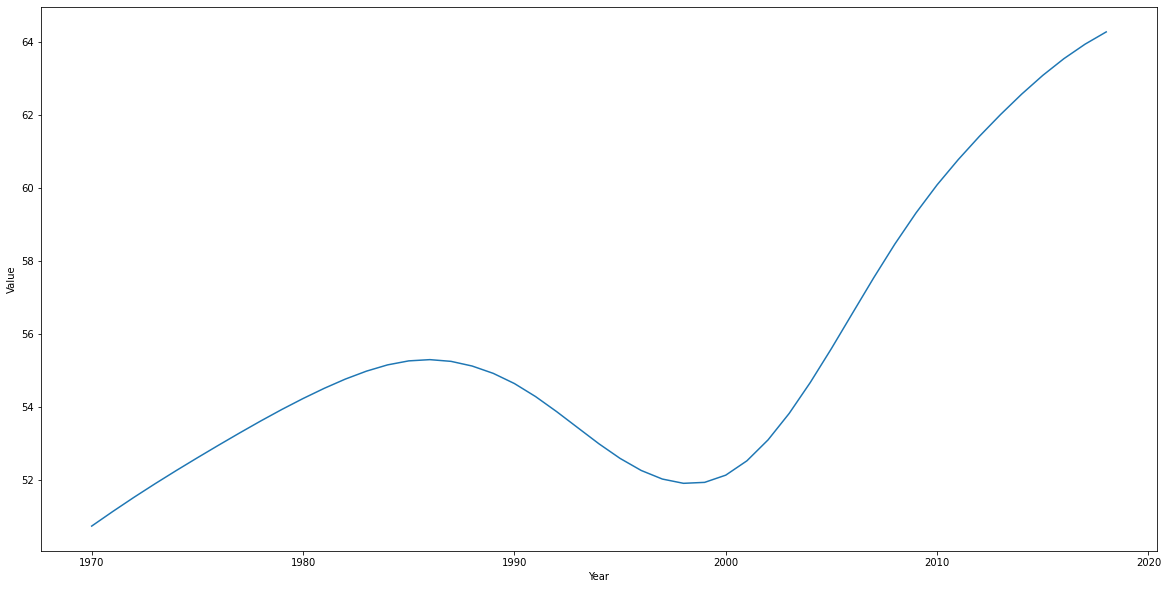

In [586]:
plt.figure(figsize=(20,10))
plt.xlabel("Year")
plt.ylabel("Value")
plt.plot(df)

In [587]:
rolmean=train_df.rolling(window=6).mean()
rolstd=train_df.rolling(window=6).std()
print(rolmean.head(15))
print(rolstd.head(15))

                Value
Year                 
1970-01-01        NaN
1971-01-01        NaN
1972-01-01        NaN
1973-01-01        NaN
1974-01-01        NaN
1975-01-01  51.683667
1976-01-01  52.053500
1977-01-01  52.412833
1978-01-01  52.762333
1979-01-01  53.102167
1980-01-01  53.431667
1981-01-01  53.749333
1982-01-01  54.052000
1983-01-01  54.334667
1984-01-01  54.591167
               Value
Year                
1970-01-01       NaN
1971-01-01       NaN
1972-01-01       NaN
1973-01-01       NaN
1974-01-01       NaN
1975-01-01  0.701404
1976-01-01  0.679497
1977-01-01  0.660729
1978-01-01  0.644610
1979-01-01  0.628758
1980-01-01  0.609979
1981-01-01  0.586075
1982-01-01  0.555097
1983-01-01  0.514944
1984-01-01  0.463067


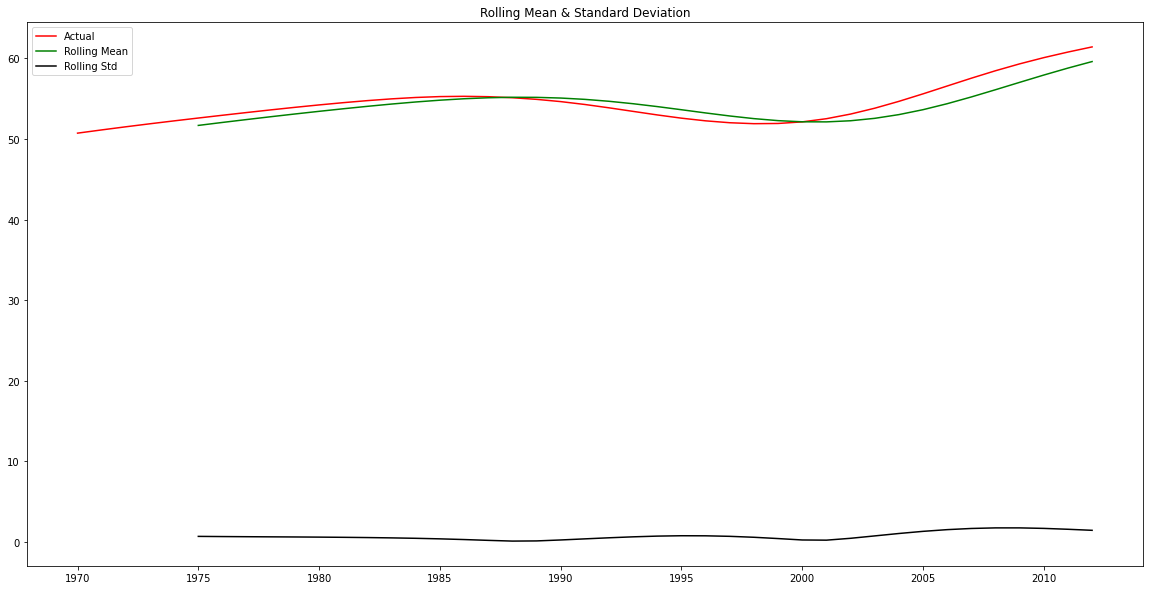

In [588]:
plt.figure(figsize=(20,10))
actual=plt.plot(train_df, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [589]:
from statsmodels.tsa.stattools import adfuller
print('Dickey-Fuller Test: ')
dftest=adfuller(train_df['Value'], autolag='AIC')
dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Dickey-Fuller Test: 
Test Statistic           2.433715
p-value                  0.999025
Lags Used                5.000000
No. of Obs              37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64


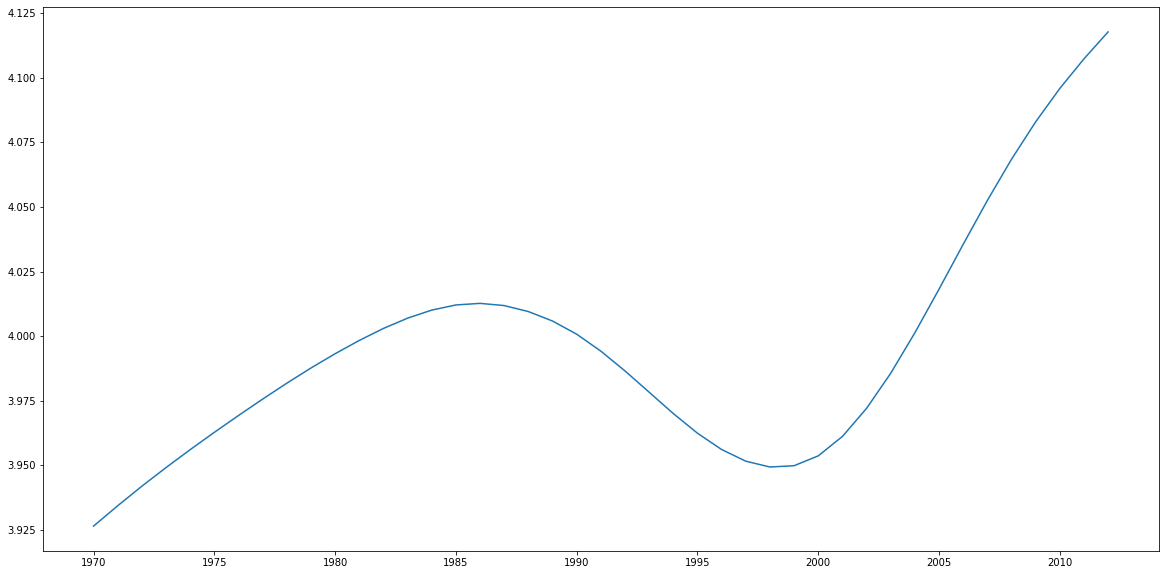

In [590]:
plt.figure(figsize=(20,10))
df_log=np.log(train_df)
plt.plot(df_log)

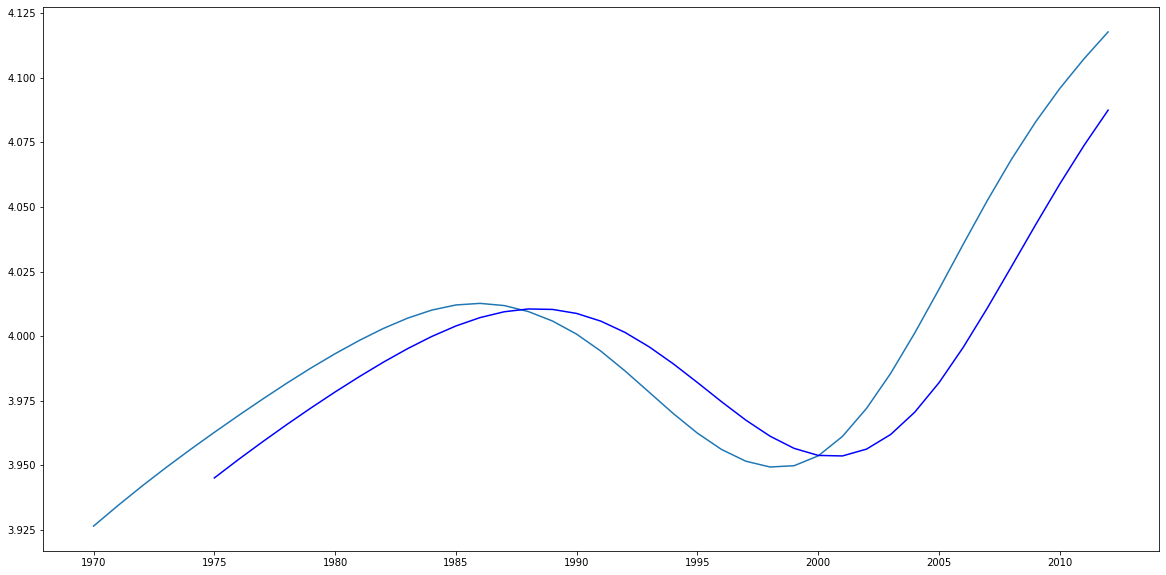

In [591]:
plt.figure(figsize=(20,10))
MAvg=df_log.rolling(window=6).mean()
MStd=df_log.rolling(window=6).std()
plt.plot(df_log)
plt.plot(MAvg, color='blue')

In [592]:
df_log_diff=df_log-MAvg
df_log_diff.head(12)

,Value
Year,
1970-01-01,NaN
1971-01-01,NaN
1972-01-01,NaN
1973-01-01,NaN
1974-01-01,NaN
1975-01-01,0.017651
1976-01-01,0.017034
1977-01-01,0.016513
1978-01-01,0.016019


In [593]:
df_log_diff=df_log_diff.dropna()
df_log_diff.head()

,Value
Year,
1975-01-01,0.017651
1976-01-01,0.017034
1977-01-01,0.016513
1978-01-01,0.016019
1979-01-01,0.015472


In [594]:
def stationarity(timeseries):
    
    rolmean=timeseries.rolling(window=6).mean()
    rolstd=timeseries.rolling(window=6).std()
    
    plt.figure(figsize=(20,10))
    actual=plt.plot(timeseries, color='red', label='Actual')
    mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
    std_6=plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller Test: ')
    dftest=adfuller(timeseries['Value'], autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

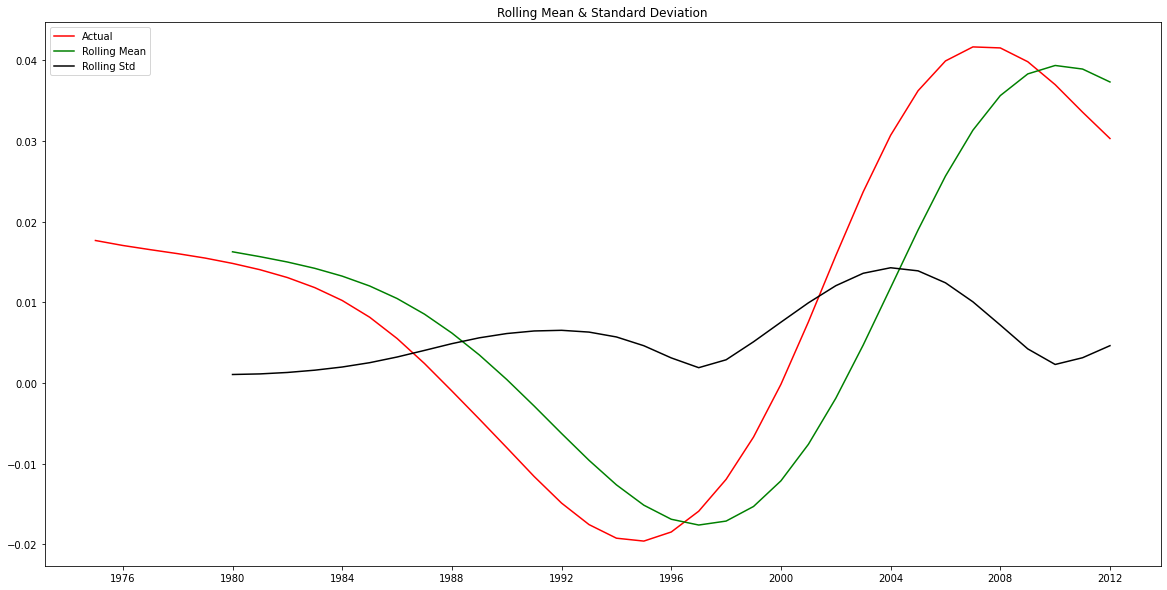

Dickey-Fuller Test: 
Test Statistic          -2.514823
p-value                  0.111909
Lags Used               10.000000
No. of Obs              27.000000
Critical Value (1%)     -3.699608
Critical Value (5%)     -2.976430
Critical Value (10%)    -2.627601
dtype: float64


In [595]:
stationarity(df_log_diff)

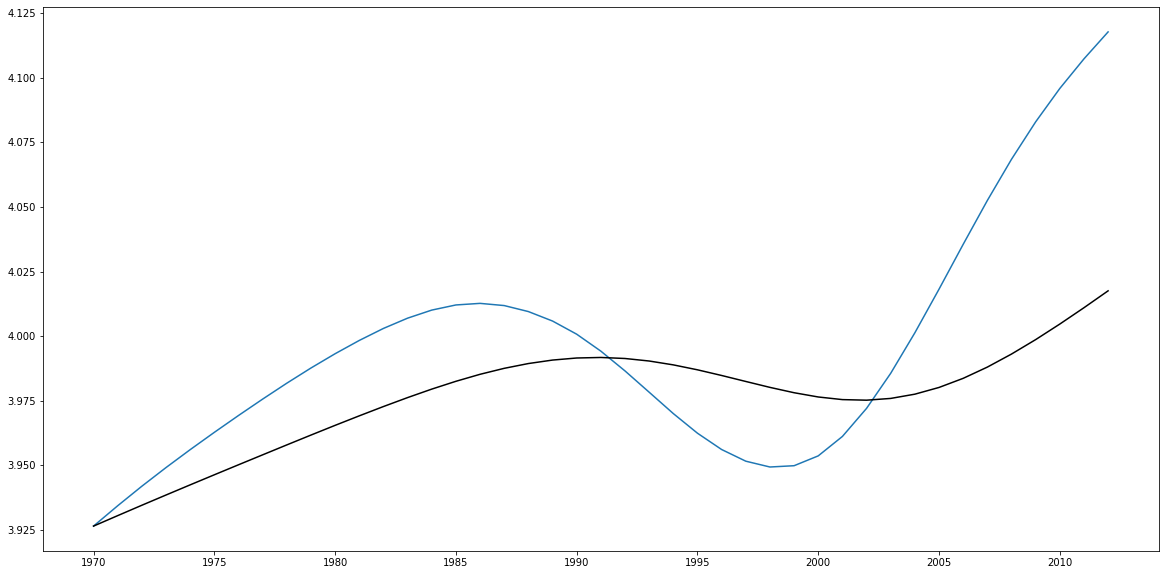

In [596]:
plt.figure(figsize=(20,10))
exp_df=df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_log)
plt.plot(exp_df, color='black')

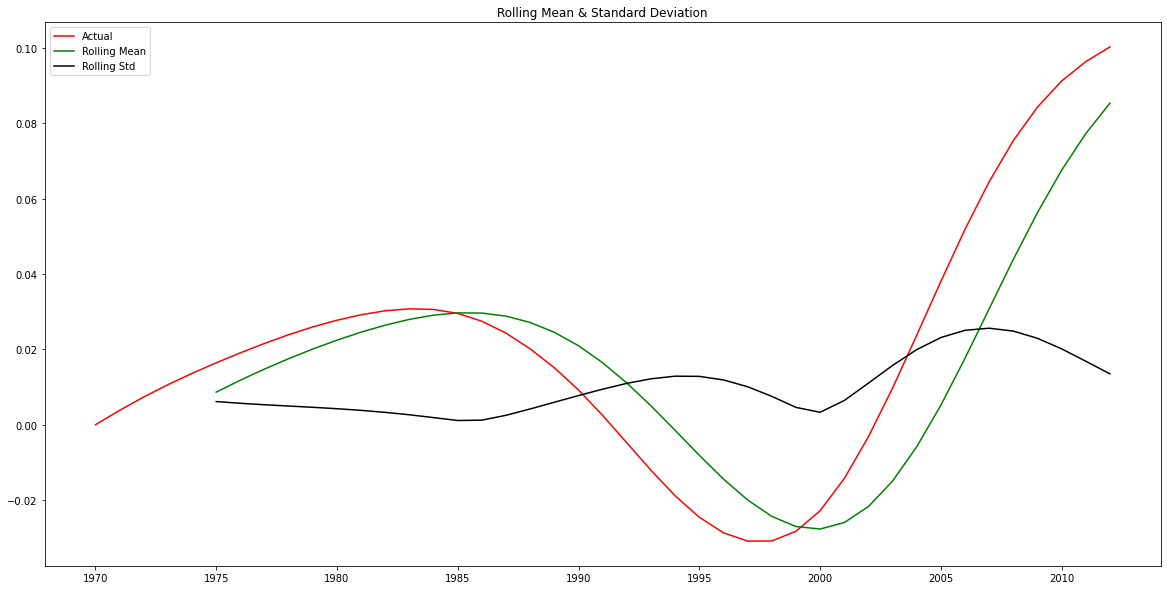

Dickey-Fuller Test: 
Test Statistic          -0.887414
p-value                  0.792089
Lags Used                7.000000
No. of Obs              35.000000
Critical Value (1%)     -3.632743
Critical Value (5%)     -2.948510
Critical Value (10%)    -2.613017
dtype: float64


In [597]:
exp_df_diff=df_log-exp_df
stationarity(exp_df_diff)

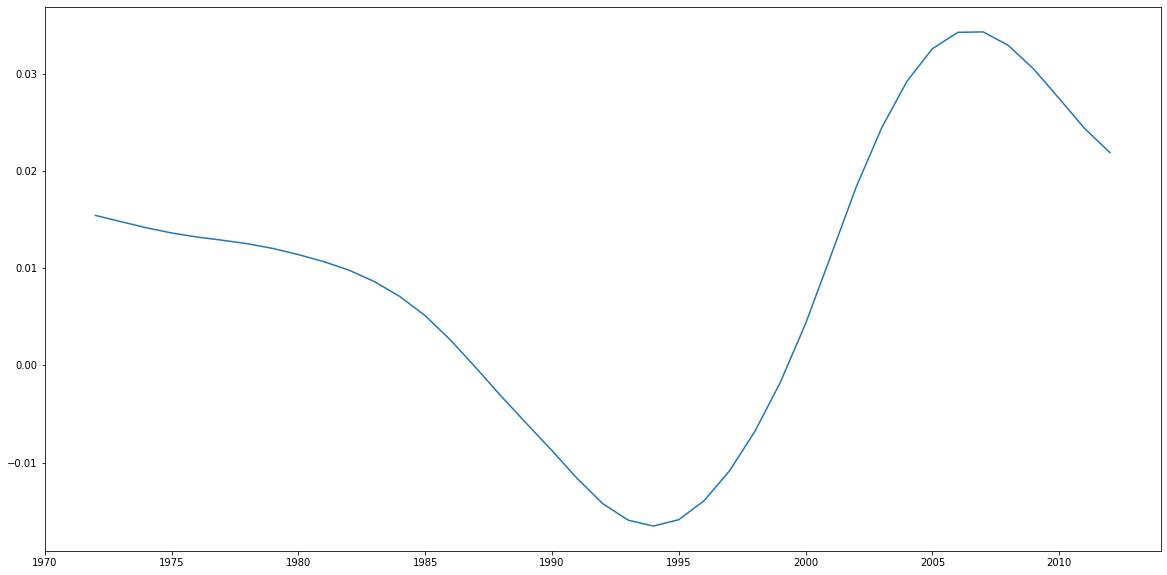

In [601]:
plt.figure(figsize=(20,10))
df_shift=df_log-df_log.shift(2)
plt.plot(df_shift)

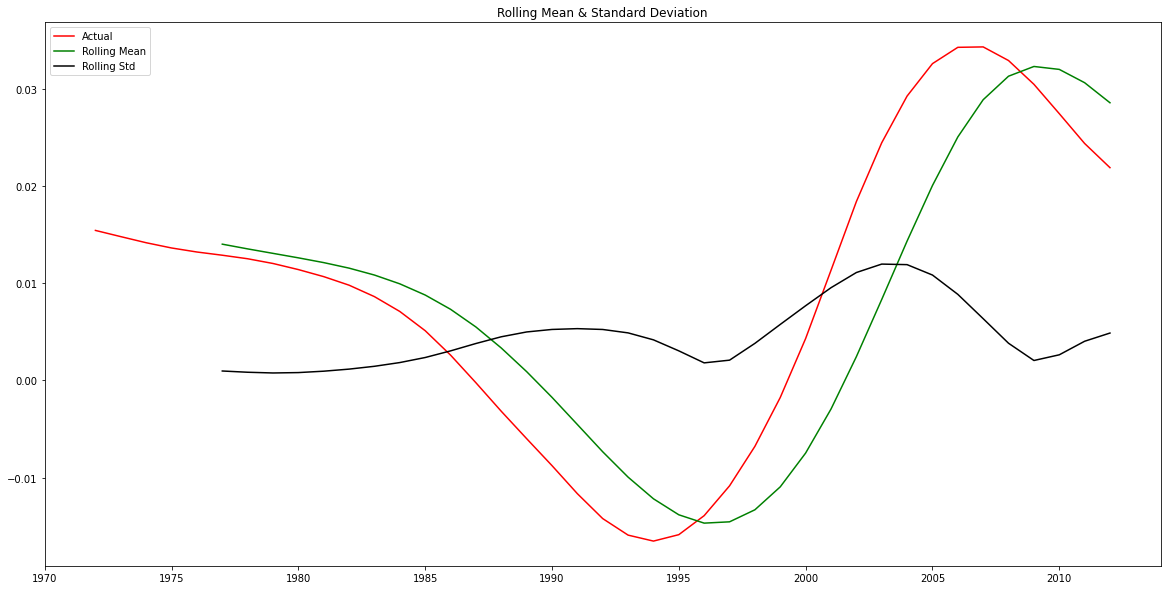

Dickey-Fuller Test: 
Test Statistic          -2.887272
p-value                  0.046848
Lags Used                9.000000
No. of Obs              31.000000
Critical Value (1%)     -3.661429
Critical Value (5%)     -2.960525
Critical Value (10%)    -2.619319
dtype: float64


In [602]:
df_shift=df_shift.dropna()
stationarity(df_shift)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

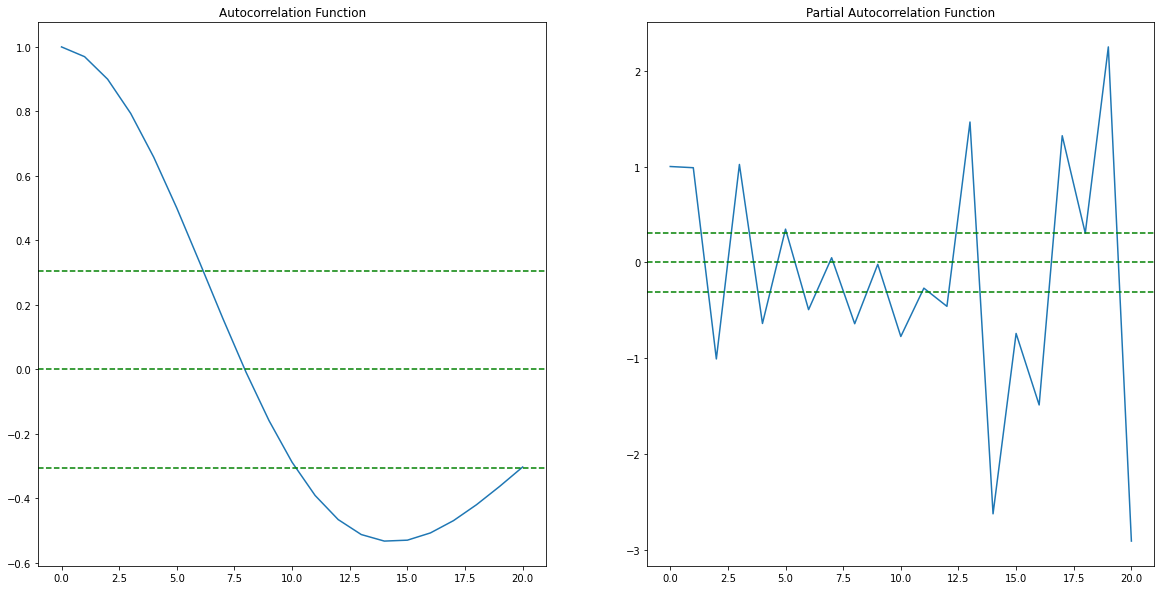

In [603]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(df_shift, nlags=20)
lag_pacf=pacf(df_shift, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(df_shift)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

plotting ARIMA model


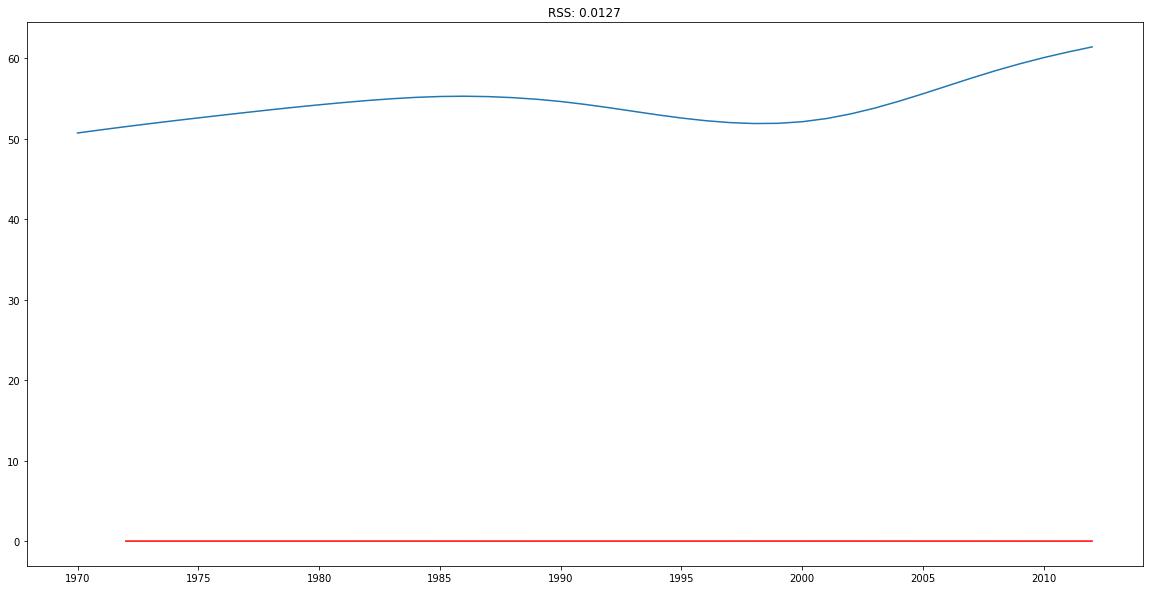

In [642]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(df_log, order=(2,2,2))
results=model.fit(disp=-1)
plt.plot(train_df)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-df_shift['Value'])**2))
print('plotting ARIMA model')

In [643]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

Year
1972-01-01    0.000199
1973-01-01   -0.000293
1974-01-01   -0.000297
1975-01-01   -0.000239
1976-01-01   -0.000146
Freq: AS-JAN, dtype: float64


In [644]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Year
1972-01-01    0.000199
1973-01-01   -0.000094
1974-01-01   -0.000391
1975-01-01   -0.000630
1976-01-01   -0.000776
Freq: AS-JAN, dtype: float64


In [645]:
predictions_log=pd.Series(df_log['Value'].iloc[0], index=df_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
#predictions_log.head()

In [646]:
arima_pred = results.predict(start = len(train_df), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred=np.exp(arima_pred)
test_df['ARIMA_Predictions'] = arima_pred
#arima_pred


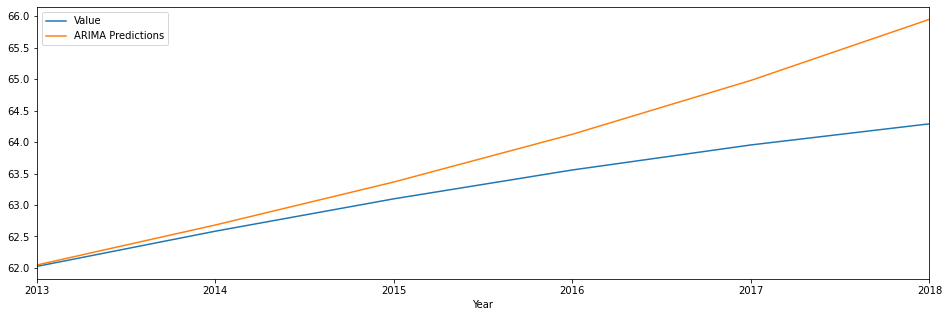

In [647]:
test_df['Value'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [648]:
arima_rmse_error = rmse(test_df['Value'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 0.7028247076797008
RMSE Error: 0.8383464126956713
Mean: 55.48387755102039


In [649]:
output=results.forecast(13)
output1=np.exp(output[0])
output1
outputs = pd.DataFrame(output1[-7:])
outputs.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs["Country"]=country_to_predict
outputs

,0,Country
2019,67.046102,Republic of Congo
2020,68.267081,Republic of Congo
2021,69.610318,Republic of Congo
2022,71.065946,Republic of Congo
2023,72.619255,Republic of Congo
2024,74.252012,Republic of Congo
2025,75.943998,Republic of Congo


In [650]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_arima.xlsx')
writer = pandas.ExcelWriter('test_arima.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [651]:
test_df

,Value,ARIMA_Predictions
Year,,
2013-01-01,62.022,62.043780
2014-01-01,62.582,62.680368
2015-01-01,63.097,63.364278
2016-01-01,63.556,64.123378
2017-01-01,63.954,64.980298
2018-01-01,64.290,65.951371


**LSTM**

In [802]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [803]:
df=pd.read_excel('test_lstm.xlsx')
df['Year']=pd.to_datetime(df.Year, format="%Y")
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df['Year']=pd.to_datetime(df['Year'], format="%Y")
df=df.set_index(['Year'])
df.index.freq = 'YS'
train_df_lstm = df[:len(df)-6]
test_df_lstm = df[len(df)-6:]
df.tail()

,Value
Year,
2014-01-01,62.582
2015-01-01,63.097
2016-01-01,63.556
2017-01-01,63.954
2018-01-01,64.290


In [804]:
scaler.fit(train_df)
scaled_train_data = scaler.transform(train_df_lstm)
scaled_test_data = scaler.transform(test_df_lstm)

In [805]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 1
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [806]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(128, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [807]:
lstm_model.fit_generator(generator,epochs=20)

Epoch 1/20
42/42 [==============================] - 0s 2ms/step - loss: 0.1375
Epoch 2/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0831
Epoch 3/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0472
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0334
Epoch 5/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 6/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0250
Epoch 7/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0230
Epoch 8/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0203
Epoch 9/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 10/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 11/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
42/42 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 13/20
42/42 [==============================

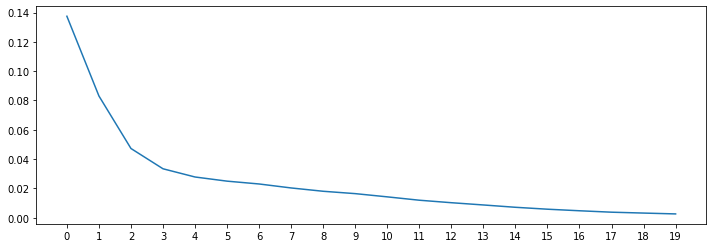

In [808]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [809]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [810]:
lstm_predictions_scaled

[array([1.0343611], dtype=float32),
 array([1.0736946], dtype=float32),
 array([1.1192698], dtype=float32),
 array([1.1728088], dtype=float32),
 array([1.2366786], dtype=float32),
 array([1.314272], dtype=float32)]

In [811]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [812]:
lstm_predictions

array([[61.7905953 ],
       [62.21138469],
       [62.69894883],
       [63.27170818],
       [63.95498767],
       [64.78508235]])

In [813]:
test_df['LSTM_Predictions'] = lstm_predictions

In [814]:
test_df

,Value,ARIMA_Predictions,LSTM_Predictions
Year,,,
2013-01-01,62.022,62.043780,61.790595
2014-01-01,62.582,62.680368,62.211385
2015-01-01,63.097,63.364278,62.698949
2016-01-01,63.556,64.123378,63.271708
2017-01-01,63.954,64.980298,63.954988
2018-01-01,64.290,65.951371,64.785082


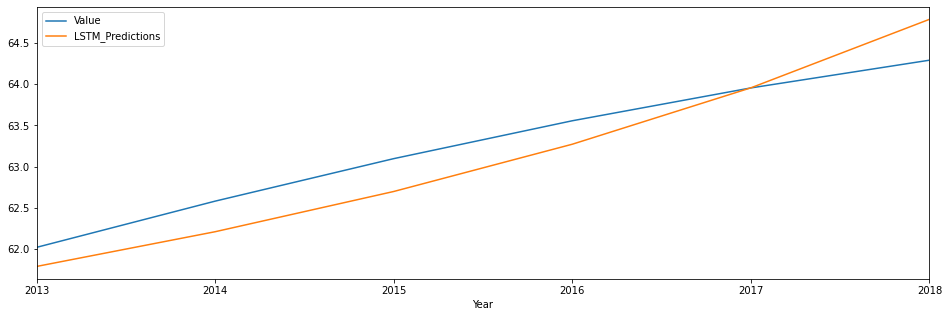

In [815]:
test_df['Value'].plot(figsize = (16,5), legend=True)
test_df['LSTM_Predictions'].plot(legend = True);

In [816]:
lstm_rmse_error = rmse(test_df['Value'], test_df["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 0.11254631979904264
RMSE Error: 0.33547923899854465
Mean: 55.48387755102039


In [817]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_df)+6):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [818]:
lstm_predictions_scaled

[array([1.0343611], dtype=float32),
 array([1.0736946], dtype=float32),
 array([1.1192698], dtype=float32),
 array([1.1728088], dtype=float32),
 array([1.2366786], dtype=float32),
 array([1.314272], dtype=float32),
 array([1.4106086], dtype=float32),
 array([1.5334102], dtype=float32),
 array([1.6951586], dtype=float32),
 array([1.9170675], dtype=float32),
 array([2.2380342], dtype=float32),
 array([2.7355924], dtype=float32)]

In [819]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [820]:
lstm_predictions

array([[61.7905953 ],
       [62.21138469],
       [62.69894883],
       [63.27170818],
       [63.95498767],
       [64.78508235],
       [65.81569133],
       [67.12942223],
       [68.85980671],
       [71.23378841],
       [74.66749039],
       [79.99036712]])

In [821]:
output2=lstm_predictions
outputs2 = pd.DataFrame(lstm_predictions[-7:])
outputs2.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
outputs2["Country"]=country_to_predict
outputs2

,0,Country
2019,64.785082,Republic of Congo
2020,65.815691,Republic of Congo
2021,67.129422,Republic of Congo
2022,68.859807,Republic of Congo
2023,71.233788,Republic of Congo
2024,74.667490,Republic of Congo
2025,79.990367,Republic of Congo


In [822]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_lstm.xlsx')
writer = pandas.ExcelWriter('test_lstm.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    outputs2.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

**Prophet**

In [823]:
df = pd.read_excel('test_prophet.xlsx')
df=df[(df['Country']==country_to_predict)]
del df["Country"]
df.head()
df_pr = df.copy()
#df = df.reset_index()
df_pr.columns = ['ds','y']
df_pr.tail()


,ds,y
142,2014,62.582
143,2015,63.097
144,2016,63.556
145,2017,63.954
146,2018,64.290


In [824]:
df_pr['ds'] = pd.to_datetime(df_pr['ds'],format="%Y")
df_pr.tail()

,ds,y
142,2014-01-01,62.582
143,2015-01-01,63.097
144,2016-01-01,63.556
145,2017-01-01,63.954
146,2018-01-01,64.290


In [825]:
train_data_pr = df_pr.iloc[:len(df)-6]
test_data_pr = df_pr.iloc[len(df)-6:]

In [826]:
from fbprophet import Prophet

In [827]:
m = Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='YS')
prophet_pred = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [828]:
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
44,2014-01-01,15.025402,63.311092,63.622315,14.896610,15.149153,48.446484,48.446484,48.446484,48.446484,48.446484,48.446484,0.0,0.0,0.0,63.471886
45,2015-01-01,15.891457,64.058368,64.600270,15.618347,16.159000,48.438737,48.438737,48.438737,48.438737,48.438737,48.438737,0.0,0.0,0.0,64.330194
46,2016-01-01,16.757513,64.725791,65.654828,16.341421,17.203304,48.419727,48.419727,48.419727,48.419727,48.419727,48.419727,0.0,0.0,0.0,65.177240
47,2017-01-01,17.625941,65.491418,66.758909,17.033413,18.301901,48.441146,48.441146,48.441146,48.441146,48.441146,48.441146,0.0,0.0,0.0,66.067087
48,2018-01-01,18.491996,66.156857,67.841894,17.699714,19.417957,48.446484,48.446484,48.446484,48.446484,48.446484,48.446484,0.0,0.0,0.0,66.938481


In [829]:
prophet_pred = pd.DataFrame({"Year" : prophet_pred[-6:]['ds'], "Pred" : prophet_pred[-6:]["yhat"]})

In [830]:
prophet_pred = prophet_pred.set_index("Year")

In [831]:
prophet_pred.index.freq = "YS"

In [832]:
prophet_pred

,Pred
Year,
2013-01-01,62.600493
2014-01-01,63.471886
2015-01-01,64.330194
2016-01-01,65.177240
2017-01-01,66.067087
2018-01-01,66.938481


In [833]:
test_df["Prophet_Predictions"] = prophet_pred['Pred'].values
test_df

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Year,,,,
2013-01-01,62.022,62.043780,61.790595,62.600493
2014-01-01,62.582,62.680368,62.211385,63.471886
2015-01-01,63.097,63.364278,62.698949,64.330194
2016-01-01,63.556,64.123378,63.271708,65.177240
2017-01-01,63.954,64.980298,63.954988,66.067087
2018-01-01,64.290,65.951371,64.785082,66.938481


In [834]:
import seaborn as sns

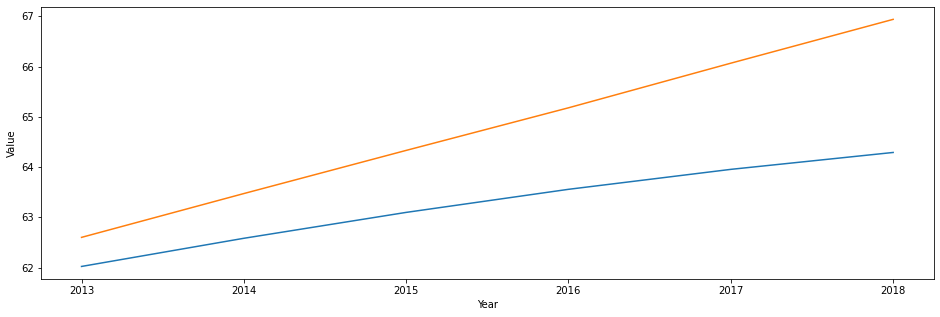

In [835]:
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_df.index, y=test_df["Value"])
sns.lineplot(x=test_df.index, y = test_df["Prophet_Predictions"]);

In [836]:
prophet_rmse_error = rmse(test_df['Value'], test_df["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Value'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 2.7925541119570223
RMSE Error: 1.6710936873667563
Mean: 55.48387755102039


In [837]:
future = m.make_future_dataframe(periods=13,freq = 'YS')
prophet_pred = m.predict(future)

In [838]:
#prophet_pred = pd.DataFrame({"Year" : prophet_pred[-11:]['ds'], "Pred" : prophet_pred[-11:]["yhat"]})
abc=prophet_pred[['ds', 'yhat']].tail(7)

In [839]:
abc.index=['2019', '2020', '2021','2022', '2023', '2024',"2025"]
del abc['ds']
abc = abc.rename(columns={'yhat': 'Value'})
abc["Country"]=country_to_predict
abc

,Value,Country
2019,67.796789,Republic of Congo
2020,68.643834,Republic of Congo
2021,69.533682,Republic of Congo
2022,70.405075,Republic of Congo
2023,71.263383,Republic of Congo
2024,72.110429,Republic of Congo
2025,73.000276,Republic of Congo


In [840]:
import pandas
from openpyxl import load_workbook

book = load_workbook('test_prophet.xlsx')
writer = pandas.ExcelWriter('test_prophet.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    abc.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index = True,header= False)

writer.save()

In [841]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

Mean: 63.25016666666667


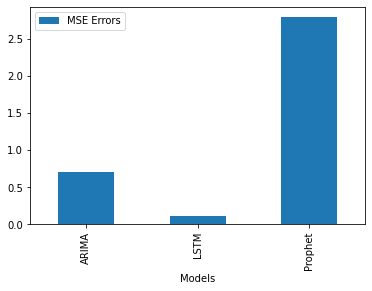

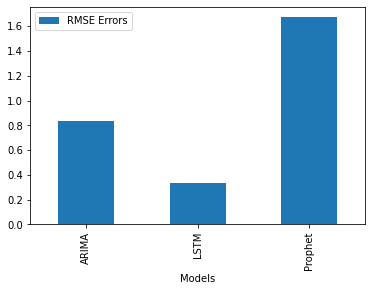

In [842]:
print(f"Mean: {test_df['Value'].mean()}")
errors
errors.plot(kind="bar",x="Models",y="MSE Errors")
errors.plot(kind="bar",x="Models",y="RMSE Errors")

In [843]:
errors["Country"]=country_to_predict
errors

,Models,RMSE Errors,MSE Errors,Country
0,ARIMA,0.838346,0.702825,Republic of Congo
1,LSTM,0.335479,0.112546,Republic of Congo
2,Prophet,1.671094,2.792554,Republic of Congo


In [844]:
import pandas
from openpyxl import load_workbook

book = load_workbook('errors.xlsx')
writer = pandas.ExcelWriter('errors.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    errors.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =False,header= False)

writer.save()

In [845]:
output3=test_df
output3["Country"]=country_to_predict
output3.reset_index()
output3.index=['2013', '2014', '2015','2016', '2017', '2018']
output3

,Value,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions,Country
2013,62.022,62.043780,61.790595,62.600493,Republic of Congo
2014,62.582,62.680368,62.211385,63.471886,Republic of Congo
2015,63.097,63.364278,62.698949,64.330194,Republic of Congo
2016,63.556,64.123378,63.271708,65.177240,Republic of Congo
2017,63.954,64.980298,63.954988,66.067087,Republic of Congo
2018,64.290,65.951371,64.785082,66.938481,Republic of Congo


In [846]:
import pandas
from openpyxl import load_workbook

book = load_workbook('comparison.xlsx')
writer = pandas.ExcelWriter('comparison.xlsx', engine='openpyxl')
writer.book = book
writer.sheets = {ws.title: ws for ws in book.worksheets}

for sheetname in writer.sheets:
    output3.to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row, index =True,header= False)

writer.save()

<Figure size 1368x648 with 0 Axes>

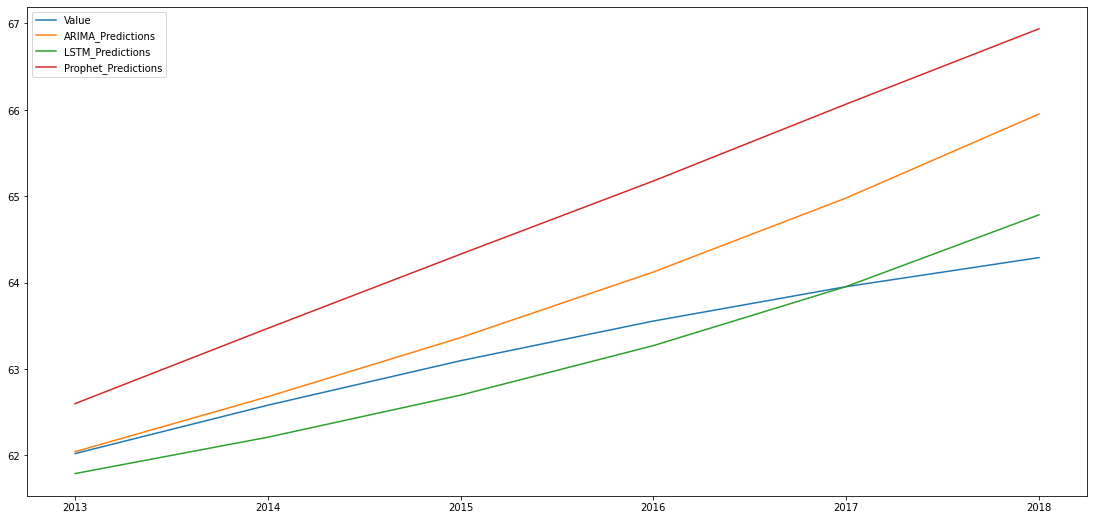

In [847]:
plt.figure(figsize=(19,9))
test_df.plot(figsize=(19,9))